In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import itertools
import heapq

In [ ]:
# --- 1. Graph Generation and Node Selection ---
def generate_graph_and_select_nodes(num_nodes,num_terminals):

    print("\n--- Generating Graph ---")
    G = nx.erdos_renyi_graph(n=num_nodes, p=0.2) # Erdos-Renyi graph

    for u, v in G.edges():
        G.edges[u, v]['weight'] = random.random() * 10 # Assign a random weight between 0 and 10

    pos = nx.spring_layout(G) # positions for all nodes

    print("\n--- Selecting Terminal Nodes ---")
    all_nodes = list(G.nodes())
    num_all_nodes = len(all_nodes)

    # Select terminals: Choose at least 2 terminals.
    # Ensure terminals are a subset of all nodes in G.
    terminals = random.sample(all_nodes, num_terminals)
    print(f"Selected Terminal nodes: {terminals}")
    steiner_nodes_potential = [node for node in all_nodes if node not in terminals]

    return G, terminals, steiner_nodes_potential, pos

G1, terminals1, steiner_nodes_potential1, pos1 = generate_graph_and_select_nodes(50,8)
G2, terminals2, steiner_nodes_potential2, pos2 = generate_graph_and_select_nodes(250,25)
G3, terminals3, steiner_nodes_potential3, pos3 = generate_graph_and_select_nodes(500,50)
G4, terminals4, steiner_nodes_potential4, pos4 = generate_graph_and_select_nodes(750,75)
G5, terminals5, steiner_nodes_potential5, pos5 = generate_graph_and_select_nodes(1000,100)


--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [1, 34, 44, 7, 17, 21, 10, 47]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [6, 148, 81, 35, 78, 169, 125, 133, 108, 82, 192, 190, 238, 60, 80, 188, 197, 15, 161, 160, 227, 145, 135, 103, 65]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [100, 56, 489, 408, 295, 367, 327, 173, 340, 2, 401, 58, 221, 366, 433, 498, 28, 108, 432, 132, 228, 176, 205, 172, 246, 483, 399, 217, 481, 274, 406, 218, 154, 446, 311, 11, 114, 413, 322, 178, 344, 3, 271, 262, 494, 24, 275, 195, 387, 368]

--- Generating Graph ---

--- Selecting Terminal Nodes ---
Selected Terminal nodes: [722, 161, 47, 439, 146, 673, 62, 535, 53, 408, 282, 411, 478, 37, 445, 460, 232, 404, 744, 364, 223, 633, 69, 742, 551, 435, 361, 384, 187, 540, 359, 418, 371, 13, 382, 594, 559, 376, 244, 586, 456, 185, 472, 34, 98, 322, 728, 634, 251, 705, 81, 459, 490, 132, 607, 578,

In [ ]:
# --- 4. KMB Algorithm Implementation ---

import time
start_time_kmb = time.time()

def kmb_steiner_tree(G, terminals):
    """
    Solves the Steiner tree problem using the Kou, Markowsky, and Berman (KMB) approximation algorithm.

    Args:
        G: A NetworkX graph with non-negative edge weights.
        terminals: A list of terminal nodes that must be included in the tree.

    Returns:
        A tuple containing:
            - A set of nodes forming the approximate Steiner tree found.
            - A list of edges forming the approximate Steiner tree found.
            - The total weight of the approximate Steiner tree.
            Returns (set(), [], float('inf')) if terminals are less than 2 or no paths exist between terminals.
    """
    if len(terminals) < 2:
        print("KMB algorithm requires at least two terminal nodes.")
        return set(), [], float('inf')

    # 1. Compute all-pairs shortest paths between all terminal nodes
    terminal_pairs_shortest_paths = {}
    terminal_pairs_shortest_distances = {}

    for i in range(len(terminals)):
        for j in range(i + 1, len(terminals)):
            source = terminals[i]
            target = terminals[j]
            try:
                path = nx.shortest_path(G, source=source, target=target, weight='weight')
                distance = nx.shortest_path_length(G, source=source, target=target, weight='weight')

                terminal_pairs_shortest_paths[(source, target)] = path
                terminal_pairs_shortest_paths[(target, source)] = list(reversed(path))
                terminal_pairs_shortest_distances[(source, target)] = distance
                terminal_pairs_shortest_distances[(target, source)] = distance

            except nx.NetworkXNoPath:
                print(f"Warning: No path found between terminal nodes {source} and {target}. KMB might not find a connected tree.")


    # 2. Construct the metric closure graph
    metric_closure_graph = nx.Graph()
    metric_closure_graph.add_nodes_from(terminals)

    for (u, v), dist in terminal_pairs_shortest_distances.items():
        if u < v:
             metric_closure_graph.add_edge(u, v, weight=dist)

    if not nx.is_connected(metric_closure_graph):
         print("Warning: Metric closure graph is not connected. Not all terminals are reachable from each other.")
         return set(), [], float('inf')


    # 3. Compute the Minimum Spanning Tree (MST) of the metric closure graph
    try:
        mst_metric_closure = nx.minimum_spanning_tree(metric_closure_graph, weight='weight')




    except nx.NetworkXNoCycle:
         print("Error: Could not compute MST of the metric closure graph.")
         return set(), [], float('inf')


    # 4. Combine all nodes and edges from the shortest paths in the original graph G
    # corresponding to the edges in the MST of the metric closure graph.
    combined_subgraph_nodes = set()
    combined_subgraph_edges = set()

    for u, v in mst_metric_closure.edges():
        path = terminal_pairs_shortest_paths.get((u, v))
        if path is None:
            path = terminal_pairs_shortest_paths.get((v, u))

        if path:
            combined_subgraph_nodes.update(path)
            path_edges = list(nx.utils.pairwise(path))
            for edge_u, edge_v in path_edges:
                 combined_subgraph_edges.add(tuple(sorted((edge_u, edge_v))))

    # Create a subgraph from the combined nodes and edges
    final_kmb_subgraph = nx.Graph()
    final_kmb_subgraph.add_nodes_from(list(combined_subgraph_nodes))
    for u, v in combined_subgraph_edges:
        if G.has_edge(u, v):
            final_kmb_subgraph.add_edge(u, v, weight=G[u][v]['weight'])
        elif G.has_edge(v, u):
             final_kmb_subgraph.add_edge(v, u, weight=G[v][u]['weight'])


    # 6. Compute the MST of this combined subgraph
    if not nx.is_connected(final_kmb_subgraph):
         print("Error: Final combined subgraph is not connected.")
         return set(), [], float('inf')

    try:
        kmb_mst = nx.minimum_spanning_tree(final_kmb_subgraph, weight='weight')
        final_kmb_tree_nodes = set(kmb_mst.nodes())
        final_kmb_tree_edges = list(kmb_mst.edges())
        final_kmb_weight = sum(kmb_mst[u][v]['weight'] for u, v in kmb_mst.edges())

        if all(term in final_kmb_tree_nodes for term in terminals):
             return final_kmb_tree_nodes, final_kmb_tree_edges, final_kmb_weight
        else:
             print("Error: Not all terminals are included in the final KMB MST.")
             return set(), [], float('inf')

    except nx.NetworkXNoCycle:
         print("Error: Could not compute MST of the final KMB subgraph.")
         return set(), [], float('inf')



In [ ]:
# Apply KMB to the generated graphs
graphs = [(G1, terminals1), (G2, terminals2), (G3, terminals3),
          (G4, terminals4), (G5, terminals5)]

kmb_results = {}
for i, (graph, terms) in enumerate(graphs):
    start_time_kmb = time.time()
    kmb_tree_nodes, kmb_tree_edges, kmb_weight = kmb_steiner_tree(graph, terms)
    end_time_kmb = time.time()
    kmb_results[f"Graph {i+1}"] = {"nodes": kmb_tree_nodes, "weight": kmb_weight, "time": end_time_kmb - start_time_kmb}

# Display the KMB results
for graph_name, result in kmb_results.items():
    print(f"\n--- KMB Results for {graph_name} ---")
    if result['nodes']:
        print(f"  KMB Approximate Steiner Tree Weight: {result['weight']:.2f}")
        print(f"  KMB Approximate Steiner Tree Nodes: {result['nodes']}")
    else:
        print("  KMB Algorithm: Could not find a connected tree containing all terminals.")
    print(f"  Time taken: {result['time']:.4f} seconds")


--- KMB Results for Graph 1 ---
  KMB Approximate Steiner Tree Weight: 14.85
  KMB Approximate Steiner Tree Nodes: {0, 1, 33, 36, 39, 40, 41, 42, 13, 46, 15, 45, 24, 26}
  Time taken: 0.0154 seconds

--- KMB Results for Graph 2 ---
  KMB Approximate Steiner Tree Weight: 15.12
  KMB Approximate Steiner Tree Nodes: {2, 131, 5, 135, 8, 10, 138, 14, 150, 151, 152, 24, 154, 28, 161, 167, 39, 174, 48, 178, 187, 67, 68, 70, 199, 201, 202, 203, 76, 204, 207, 82, 210, 216, 89, 218, 91, 220, 94, 95, 226, 100, 229, 101, 103, 232, 233, 104, 102, 108, 238, 114, 116, 118, 119, 249, 122, 127}
  Time taken: 2.0988 seconds

--- KMB Results for Graph 3 ---
  KMB Approximate Steiner Tree Weight: 12.66
  KMB Approximate Steiner Tree Nodes: {13, 18, 26, 41, 50, 53, 55, 65, 69, 73, 77, 78, 80, 83, 91, 93, 96, 99, 100, 102, 103, 106, 107, 111, 114, 116, 118, 123, 124, 127, 128, 133, 134, 138, 140, 141, 145, 147, 157, 163, 166, 183, 192, 195, 196, 209, 216, 218, 223, 226, 234, 237, 240, 245, 250, 252, 255, 2

In [ ]:
import heapq
import networkx as nx
import time

def greedy_steiner_tree(G, terminals):
    """
    Optimized Greedy Steiner Tree:
    - Retains greedy expansion nature.
    - Much faster than naive greedy and KMB.
    """
    if not terminals:
        return set(), [], float('inf')

    start_time = time.time()

    # Initialize structures
    tree_nodes = {terminals[0]}
    connected_terminals = {terminals[0]}
    tree_edges = set()
    total_weight = 0.0

    # Mark all nodes initially unvisited
    visited = {n: False for n in G.nodes()}
    for t in tree_nodes:
        visited[t] = True

    # Priority queue: (weight, u, v)
    pq = []
    for u in tree_nodes:
        for v, data in G[u].items():
            heapq.heappush(pq, (data['weight'], u, v))

    while connected_terminals != set(terminals) and pq:
        w, u, v = heapq.heappop(pq)

        if visited[v]:
            continue

        # Add new node/edge to the tree
        visited[v] = True
        tree_edges.add(tuple(sorted((u, v))))
        tree_nodes.add(v)
        total_weight += w

        if v in terminals:
            connected_terminals.add(v)

        # Add v’s neighbors to the heap
        for nbr, data in G[v].items():
            if not visited[nbr]:
                heapq.heappush(pq, (data['weight'], v, nbr))

    # Optional: prune unnecessary nodes (non-terminal leaves)
    pruned_tree = nx.Graph()
    pruned_tree.add_edges_from(tree_edges)
    pruned_tree = prune_non_terminal_leaves(pruned_tree, terminals)

    total_weight = sum(G[u][v]['weight'] for u, v in pruned_tree.edges())

    return set(pruned_tree.nodes()), list(pruned_tree.edges()), total_weight


def prune_non_terminal_leaves(G_sub, terminals):
    """
    Removes non-terminal leaves to reduce unnecessary nodes in the greedy tree.
    """
    changed = True
    while changed:
        changed = False
        leaves = [n for n in G_sub.nodes() if G_sub.degree(n) == 1 and n not in terminals]
        if leaves:
            G_sub.remove_nodes_from(leaves)
            changed = True
    return G_sub


In [ ]:
# Apply Greedy algorithm to the generated graphs
graphs = [(G1, terminals1), (G2, terminals2), (G3, terminals3),
          (G4, terminals4), (G5, terminals5)]

greedy_results = {}
for i, (graph, terms) in enumerate(graphs):
    start_time_greedy = time.time()
    greedy_tree_nodes, greedy_tree_edges, greedy_weight = greedy_steiner_tree(graph, terms)
    end_time_greedy = time.time()
    greedy_results[f"Graph {i+1}"] = {"nodes": greedy_tree_nodes, "weight": greedy_weight, "time": end_time_greedy - start_time_greedy}

# Display the Greedy results
for graph_name, result in greedy_results.items():
    print(f"\n--- Greedy Results for {graph_name} ---")
    if result['nodes']:
        print(f"  Greedy Approximate Steiner Tree Weight: {result['weight']:.2f}")
        print(f"  Greedy Approximate Steiner Tree Nodes: {result['nodes']}")
    else:
        print("  Greedy Algorithm: Could not find a connected tree containing all terminals.")
    print(f"  Time taken: {result['time']:.4f} seconds")


--- Greedy Results for Graph 1 ---
  Greedy Approximate Steiner Tree Weight: 19.86
  Greedy Approximate Steiner Tree Nodes: {0, 1, 3, 4, 5, 7, 9, 11, 13, 15, 17, 20, 24, 25, 26, 27, 35, 36, 37, 39, 40, 41, 42, 45, 46, 47, 48}
  Time taken: 0.0011 seconds

--- Greedy Results for Graph 2 ---
  Greedy Approximate Steiner Tree Weight: 17.64
  Greedy Approximate Steiner Tree Nodes: {0, 1, 2, 4, 5, 6, 8, 10, 14, 20, 21, 24, 31, 35, 37, 41, 48, 50, 54, 59, 61, 64, 67, 68, 69, 70, 72, 76, 82, 89, 91, 94, 95, 96, 99, 100, 101, 103, 113, 116, 117, 118, 119, 122, 124, 127, 128, 131, 135, 137, 138, 143, 144, 151, 152, 154, 161, 166, 167, 171, 174, 177, 178, 179, 187, 191, 193, 198, 201, 202, 203, 204, 205, 206, 207, 209, 210, 212, 214, 215, 216, 226, 229, 232, 236, 237, 238, 243, 247}
  Time taken: 0.0144 seconds

--- Greedy Results for Graph 3 ---
  Greedy Approximate Steiner Tree Weight: 15.16
  Greedy Approximate Steiner Tree Nodes: {5, 13, 14, 18, 21, 26, 41, 50, 53, 62, 65, 69, 72, 73, 75, 7

In [ ]:
import pandas as pd

comparison_data = []
graphs = [G1, G2, G3, G4, G5] # List of graph objects

for i, graph in enumerate(graphs):
    graph_name = f"Graph {i+1}"
    num_nodes = graph.number_of_nodes() # Get the actual number of nodes

    comparison_data.append({
        'Number of Nodes': num_nodes,
        'Algorithm': 'KMB',
        'Weight': kmb_results[graph_name]['weight'],
        'Runtime (s)': kmb_results[graph_name]['time'],
        'Steiner Nodes': len(kmb_results[graph_name]['nodes']) if kmb_results[graph_name]['nodes'] else 0
    })
    comparison_data.append({
        'Number of Nodes': num_nodes,
        'Algorithm': 'Greedy',
        'Weight': greedy_results[graph_name]['weight'],
        'Runtime (s)': greedy_results[graph_name]['time'],
        'Steiner Nodes': len(greedy_results[graph_name]['nodes']) if greedy_results[graph_name]['nodes'] else 0
    })

comparison_df = pd.DataFrame(comparison_data)

print(comparison_df)

   Number of Nodes Algorithm     Weight  Runtime (s)  Steiner Nodes
0               50       KMB  14.851793     0.015408             14
1               50    Greedy  19.864835     0.001078             27
2              250       KMB  15.122632     2.098775             58
3              250    Greedy  17.644577     0.014387             89
4              500       KMB  12.656701    29.129953            115
5              500    Greedy  15.164233     0.046330            171
6              750       KMB  12.977128   144.454242            168
7              750    Greedy  15.708207     0.094592            248
8             1000       KMB  13.252335   437.586088            215
9             1000    Greedy  16.887391     0.177119            347


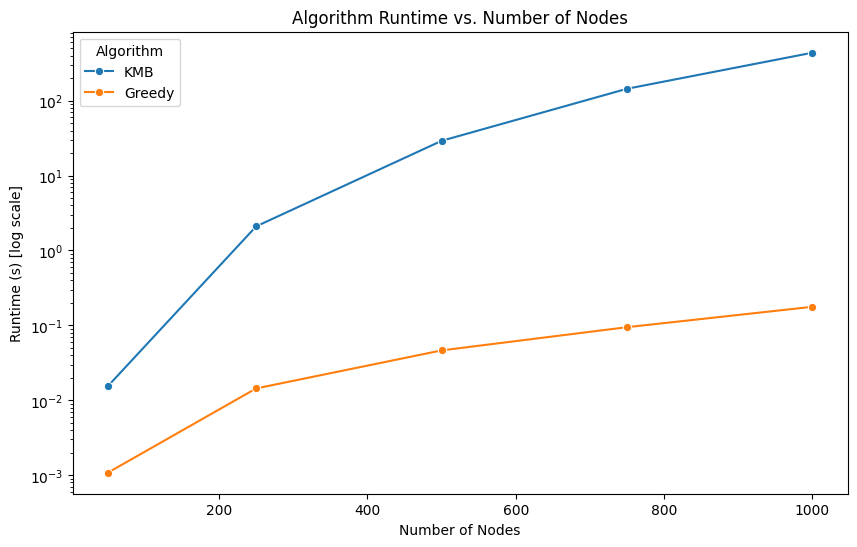

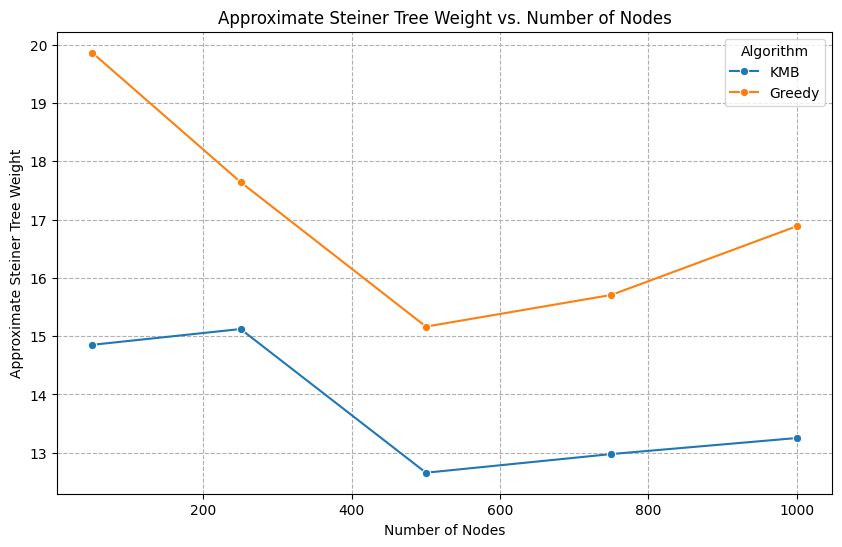

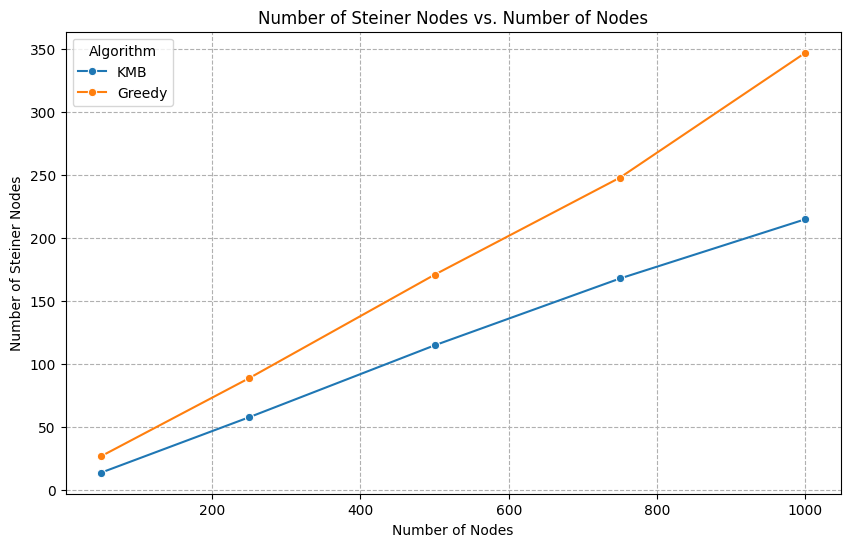

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Plotting Runtime vs. Number of Nodes
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='Number of Nodes', y='Runtime (s)', hue='Algorithm', marker='o')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Algorithm Runtime vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Runtime (s) [log scale]')
plt.show()

# Plotting Weight vs. Number of Nodes (optional, but good for comparison)
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='Number of Nodes', y='Weight', hue='Algorithm', marker='o')
plt.title('Approximate Steiner Tree Weight vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Approximate Steiner Tree Weight')
plt.grid(True, which="both", ls="--")
plt.show()

# Plotting Steiner Nodes vs. Number of Nodes (optional)
plt.figure(figsize=(10, 6))
sns.lineplot(data=comparison_df, x='Number of Nodes', y='Steiner Nodes', hue='Algorithm', marker='o')
plt.title('Number of Steiner Nodes vs. Number of Nodes')
plt.xlabel('Number of Nodes')
plt.ylabel('Number of Steiner Nodes')
plt.grid(True, which="both", ls="--")
plt.show()